In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
most_recent_date = session.query(func.max(Measurement.date)).scalar()
most_recent_date

'2017-08-23'

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Ensure most_recent_date is in correct datetime format
most_recent_date = datetime.strptime(most_recent_date, "%Y-%m-%d")

# Calculate the date one year from the last date in data set.
year_ago = most_recent_date - timedelta(days= 366)

# Perform a query to retrieve the data and precipitation scores
precipitation_data = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= year_ago).\
    order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
precip_df = pd.DataFrame(precipitation_data, columns=['Date', 'Precipitation'])

# Make sure 'Date' column in is datetime format
precip_df['Date'] = pd.to_datetime(precip_df['Date'])

# Sort the dataframe by date
precip_df.sort_values(by='Date', inplace=True)


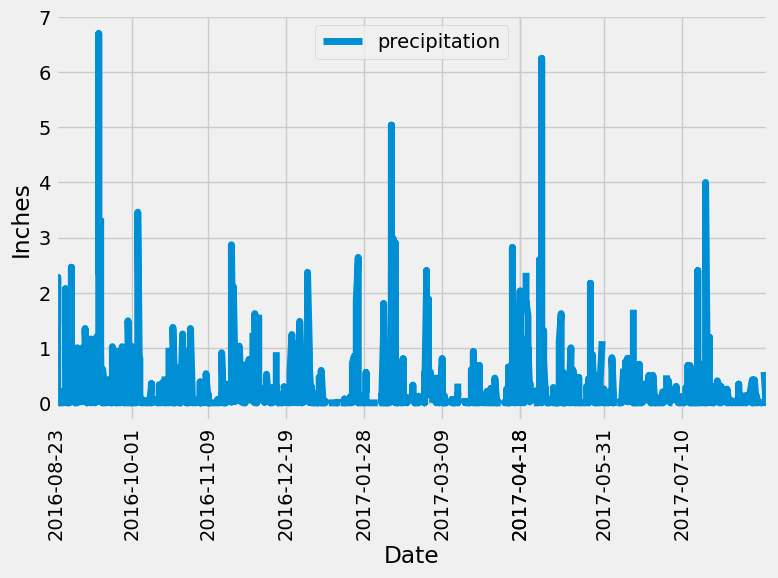

In [45]:

# Use Pandas Plotting with Matplotlib to plot the data
plt.figure(figsize=(8, 6))

# Manually setting tick locations to fit example from Mod 10 Challenge image by hardcoding tick locations into a list
tick_loc = ['2016-08-23', '2016-10-01', '2016-11-09', '2016-12-19', '2017-01-28', '2017-03-09', '2017-04-18', '2017-04-18', '2017-05-31', '2017-07-10']

# Plot and format
plt.plot(precip_df['Date'], precip_df['Precipitation'], label='precipitation', linewidth=5)
plt.xlabel('Date')
plt.ylabel('Inches')
plt.xticks(rotation= 'vertical', ticks=tick_loc)
plt.legend(loc='upper center')

# Set the x limit
plt.xlim(precip_df['Date'].min(), precip_df['Date'].max())

# Adjust the layout to save space
plt.tight_layout()

# Show plot
plt.show()


In [12]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_stats = precip_df['Precipitation'].describe()

# Create a DataFrame to display data nicely
summary_stats_df = pd.DataFrame(summary_stats)

#Display summary stats
summary_stats_df

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [13]:
# Design a query to calculate the total number of stations in the dataset
station_count = session.query(func.count(Measurement.station.distinct())).scalar()
station_count                        


9

In [14]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
most_active = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
most_active

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [15]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.

# Save the most active station ID in a variable
most_active_id = most_active[0][0]

# Query min, max, avg each individually and save to variable
min_temp = session.query(func.min(Measurement.tobs)).filter(Measurement.station == most_active_id).one()
max_temp = session.query(func.max(Measurement.tobs)).filter(Measurement.station == most_active_id).one()
avg_temp = session.query(func.avg(Measurement.tobs)).filter(Measurement.station == most_active_id).one()

# Print results
print(min_temp)
print(max_temp)
print(avg_temp)

(54.0,)
(85.0,)
(71.66378066378067,)


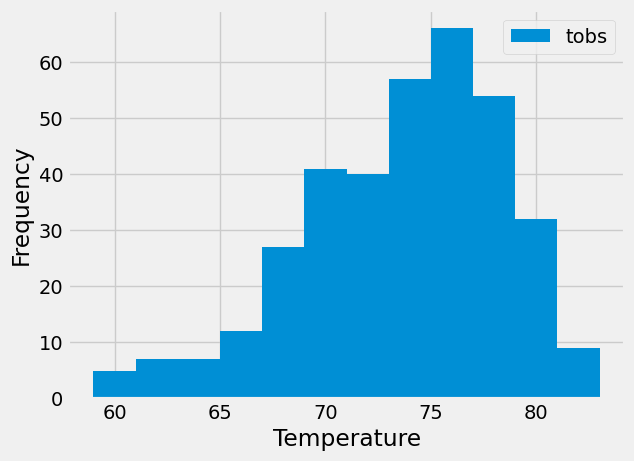

In [16]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

# Find the most recent date for the most active station
station_recent_date = (
    session.query(func.max(Measurement.date))
    .filter(Measurement.station == most_active_id)
    .scalar()
)

# Ensure station_recent_date is in the correct datetime format
station_recent_date = datetime.strptime(station_recent_date, "%Y-%m-%d")

# Find the year ago date from the most active station
station_year_ago = station_recent_date - timedelta(days= 366)

# Query to find temperature data from the last 366 days 
temperature_data = (
    session.query(Measurement.tobs)
    .filter(
        Measurement.station == most_active_id,
        Measurement.date >= station_year_ago
    )
    .all()
)

# Save the temperatures into a list
temperatures = [temp[0] for temp in temperature_data]

# Plot the temperatures
plt.hist(temperatures, bins=12, label="tobs")
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Close Session

In [17]:
# Close Session
session.close()